# [Analyse] du discours d'un climato-sceptique: François Gervais. (1/2) 
 Watch [le reveilleur](https://www.youtube.com/watch?v=XGq4WRTLfvc) to place this study into context. We discuss, with a data scientist point of view, the fitting procedure used to obtain Fig. 2 and Fig. 3 extracted from [1]
<br><br>We Fit the yearly/monthly earth mean temperature anomaly $\delta T(t)$ using the objective function: $$\begin{array}{l}
\\
\delta T(t) = a + bt + c\sin \left( {\frac{{2\pi t}}{T} + \varphi } \right)
\end{array}$$ <br>with $t \in \left[ {1850,2019} \right]$. The data are available [here](https://www.metoffice.gov.uk/hadobs/hadcrut4/data/current/download.html) (choose Global (NH+SH)/2  **per month**. Copy and paste the data in a texte file. 
<br><br>The data are organized as follow :
- Column 0 is the date.
- Column 1 is the median of the 100 ensemble member time series.
- Columns 2 and 3 are the lower and upper bounds of the 95% confidence interval of bias uncertainty computed from the 100 member ensemble.
- Columns 4 and 5 are the lower and upper bounds of the 95% confidence interval of measurement and sampling uncertainties around the ensemble median. These are the combination of fully uncorrelated measurement and sampling uncertainties and partially correlated uncertainties described by the HadCRUT4 error covariance matrices.
- Columns 6 and 7 are the lower and upper bounds of the 95% confidence interval of coverage uncertainties around the ensemble median.
- Columns 8 and 9 are the lower and upper bounds of the 95% confidence interval of the combination of measurement and sampling and bias uncertainties.
- Columns 10 and 11 are the lower and upper bounds of the 95% confidence interval of the combined effects of all the uncertainties described in the HadCRUT4 error model (measurement and sampling, bias and coverage uncertainties).

For further information François-Marie Béon wrote a critical review of the Gervais' book [here](https://www.lemonde.fr/sciences/article/2013/10/28/les-contre-verites-du-dernier-pamphlet-climatosceptique_3504317_1650684.html). 
- [1] [Gervais,F. *Anthropogenic CO 2 Warming Challenged by 60-Year Cycle* Earth-Science Reviews 155 (2016)](www.sciencedirect.com/science/article/abs/pii/S0012825216300277)


ajustement sur la période de 1855 à 2019

type de moyenne : annuelle

matrice de corrélation:

         a      b     am      T    phi
a    1.000  0.407 -0.617  0.639  0.642
b    0.407  1.000 -0.945  0.962  0.960
am  -0.617 -0.945  1.000 -0.980 -0.981
T    0.639  0.962 -0.980  1.000  1.000
phi  0.642  0.960 -0.981  1.000  1.000

 coefficients (a+b.t+am.(sin(2.pi.t/T+phi)):
                        
a =    -0.636 ± 0.039 °C
b =     0.006 ± 0.0 °C/y
am =    0.173 ± 0.015 °C
T =      69.57 ± 2.068 y
phi =   0.06 ± 0.312 rad

ajustement sur la période de 1875 à 2019

type de moyenne : annuelle

matrice de corrélation:

         a      b     am      T    phi
a    1.000 -1.000  0.994  0.999  0.999
b   -1.000  1.000 -0.994 -0.997 -0.998
am   0.994 -0.994  1.000  0.994  0.994
T    0.999 -0.997  0.994  1.000  1.000
phi  0.999 -0.998  0.994  1.000  1.000

 coefficients (a+b.t+am.(sin(2.pi.t/T+phi)):
                        
a =    -0.565 ± 0.039 °C
b =     0.007 ± 0.0 °C/y
am =    0.166 ± 0.016 °

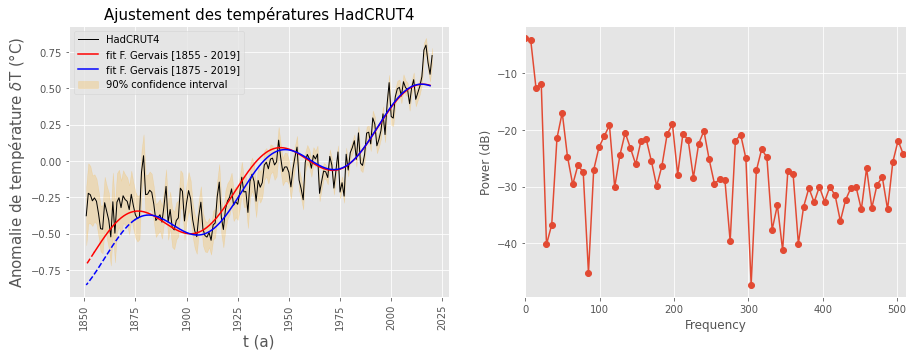

In [1]:
'''Fits the Fig.2 of the HadCRUT4 file availabable under:
https://www.metoffice.gov.uk/hadobs/hadcrut4/data/current/download.html
with the function a*t+b+c*sin(2*pi*t/T+phi)
auteur F. Bertin'''

from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import bisect
import itertools as it
from spectrum import *
import os
%matplotlib inline

# initialization

directory_path=u"C:\Expert senior\coursera\ecologie"
file_name="HadCRUT4m.txt"
os.chdir(directory_path)
mean_type="Y" # "Y" average anomaly temperaturesover a year 
              # "M" average anomaly temperaturesover a month Gervais takes "M"

years_min=[1855,1875] # initial year (yyyy.yy) for the fit Gervais takes year_min=1875
year_max=2019 # final year (yyyy.yy) for the fit
a,b,amp,T,phase=-0.5,0.006,0.1,60,0 # fitting parameters initialization

def Gervais(year,a,b,amp,T,phase): # fitting model
    year=year-year[0]
    return a+b*(year)+amp*np.sin(2*np.pi*(year)/T+phase)

def print_result():
    print(f"\najustement sur la période de {year_min} à {year_max}\n" )
    moy={"Y":"annuelle","M":"mensuelle"}
    print(f"type de moyenne : {moy[mean_type]}\n")
    print("matrice de corrélation:\n")
    df = pd.DataFrame(cov,columns=["a","b",'am','T','phi'])
    print(df.corr().round(3))
    print("\n coefficients (a+b.t+am.(sin(2.pi.t/T+phi)):")
    error=[np.absolute(cov[i][i])**0.5 for i in range(len(c))]
    error=[round(x,3) for x in error]
    print(pd.DataFrame([str(x[0])+" ± "+str(x[1])+" "+x[2] for x in zip(c,error,["°C","°C/y","°C","y","rad"])]
                       ,columns=[""],index=["a =","b =",'am =','T =','phi =']))


# recast the text file as a data frame
df=pd.read_csv("HadCRUT4m.txt",sep="\s+",header=None,index_col=0,parse_dates=True)
df=df.loc[:,:].resample(mean_type).mean()
year= np.array([(float(d.strftime("%j"))-1) / 366 + float(d.strftime("%Y")) for d in df.index])
temp=np.array(df[1] )

# plot the raw data
plt.style.use('ggplot')
fig=plt.figure(figsize=(15,5))
ax = plt.subplot(121)
plt.plot(year,temp ,'k',label="HadCRUT4",linewidth=1)
plt.fill_between(year,list(df[8]),list(df[9]), alpha=0.2, color='Orange',label='90% confidence interval')
plt.xticks(rotation=90)
plt.xlabel("t (a)",size=15)
plt.ylabel("Anomalie de température $\delta$T (°C)",size=15)
every_nth = 1
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

# fit and plot results
for x in zip(it.cycle('rbky'),years_min):
    year_min=x[1]
    col=x[0]
    c=[a,b,amp,T,phase]
    sigma=np.array(df[9])-np.array(df[8])
    index_min=max(0,bisect.bisect(year,year_min)-1)
    index_max=min(len(year)-1,bisect.bisect(year,year_max))
    year_fit=year[index_min:index_max]
    temp_fit=temp[index_min:index_max]
    sigma_fit=sigma[index_min:index_max]
    c,cov = curve_fit(Gervais,year_fit,temp_fit, [a,b,amp,T,phase],sigma_fit,absolute_sigma=True)
    R=r2_score(temp_fit,Gervais(year_fit,*c))
    
    year_plot=np.linspace(min(year_fit),max(year_fit),8000)
    temp_plot=Gervais(year_plot,*c)
    label=f'fit F. Gervais [{year_min} - {year_max}]'
    plt.plot(year_plot ,temp_plot,col,label=label)
    year_plot=np.linspace(min(year_plot),min(year),8000)
    temp_plot=Gervais(year_plot,*c)
    plt.plot(year_plot ,temp_plot,"--"+col) #,label="Modèle F. Gervais extrapolé")
    plt.legend(loc=0)
    c=[round(x,3) for x in c]
    plt.title('Ajustement des températures HadCRUT4',size=15)
    result='$\delta$T = {} + {} t + {}sin(2$\pi$t/{}+ {}) \n $r^2$={}'.format(*c,R)
    if len(years_min)==1 : ax.text(1870, 0.25 , result, fontsize=10)
    print_result()

# spectral analysis
ax1 = plt.subplot(122)
p = Periodogram(temp_fit, sampling=1024, window='hann')
p.plot(marker='o')
plt.style.use('default')